# 🫁 Qwen2.5 Chest X-ray Classification

Classify each chest X-ray as 'healthy' or 'unhealthy' using Qwen2.5 and evaluate with accuracy/F1.

## 1. Setup & Imports

In [ ]:
import os, json, base64
from openai import OpenAI
from dotenv import load_dotenv
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score
from PIL import Image, ImageDraw, ImageFont
import numpy as np
%matplotlib inline

def encode_image_to_data_uri(path: str) -> str:
    with open(path, "rb") as f:
        b64 = base64.b64encode(f.read()).decode('utf-8')
    return f"data:image/png;base64,{b64}"

DATASET_DIR = "VLM-Seminar25-Dataset/chest_xrays"
IMAGES_DIR = os.path.join(DATASET_DIR, "images")
ANNOT_PATH = os.path.join(DATASET_DIR, "annotations_len_50.json")
RESULTS_DIR = "../results/chest_xrays/classification"

os.makedirs(RESULTS_DIR, exist_ok=True)

with open(ANNOT_PATH, "r") as f:
    annotations = json.load(f)
image_ids = list(annotations.keys())
print(f"Number of images in the dataset: {len(image_ids)}")

load_dotenv(dotenv_path="../config/user.env")
api_key = os.environ.get("NEBIUS_API_KEY")
client = OpenAI(base_url="https://api.studio.nebius.com/v1/", api_key=api_key)

Number of images in the dataset: 50


In [13]:
do_new_inference = False

## 2. Model Inference

In [8]:
classification_results = []
if do_new_inference:
    for img_id in tqdm(image_ids):
        img_path = os.path.join(IMAGES_DIR, img_id + ".png")
        data_uri = encode_image_to_data_uri(img_path)
        prompt = "Given the medical image, classify it as 'healthy' or 'unhealthy'. Only output only either 'healthy' or 'unhealthy'."
        completion = client.chat.completions.create(
            model="Qwen/Qwen2.5-VL-72B-Instruct",
            messages=[
                {
                    "role": "user",
                    "content": [
                        {"type": "text", "text": prompt},
                        {"type": "image_url", "image_url": {"url": data_uri}},
                    ],
                }
            ],
        )
        pred = completion.choices[0].message.content.strip().lower()
        classification_results.append({"id": img_id, "prediction": pred})

100%|██████████| 50/50 [07:52<00:00,  9.45s/it]


## 3. Save Model Predictions

In [17]:
# Save predictions
with open(os.path.join(RESULTS_DIR, "qwen2_5_classification_results.json"), "w") as f:
    json.dump(classification_results, f, indent=2)
print("Saved classification results.")

Saved classification results.


Load results

In [14]:
with open(os.path.join(RESULTS_DIR, "qwen2_5_classification_results.json"), "r") as f:
    classification_results = json.load(f)
print(f"Number of images classified: {len(classification_results)}")

Number of images classified: 50


## 4. Evaluation & Metrics

In [15]:
gt = [annotations[x["id"]]["status"] for x in classification_results]
pred = [x["prediction"] for x in classification_results]

accuracy = accuracy_score(gt, pred)
f1 = f1_score(gt, pred, pos_label='unhealthy')
print(f"Accuracy: {accuracy:.3f}")
print(f"F1 Score: {f1:.3f}")

# Save evaluation metrics
eval_metrics = {"accuracy": accuracy, "f1": f1}
with open(os.path.join(RESULTS_DIR, "classification_eval_metrics.json"), "w") as f:
    json.dump(eval_metrics, f, indent=2)
print("Saved evaluation metrics.")

Accuracy: 0.560
F1 Score: 0.476
Saved evaluation metrics.


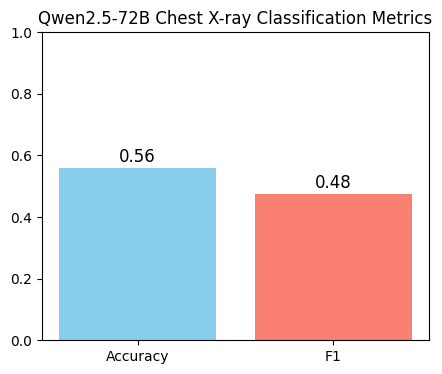

Saved metrics plot.


In [17]:
plt.figure(figsize=(5,4))
plt.bar(["Accuracy", "F1"], [accuracy, f1], color=["skyblue", "salmon"])
plt.ylim(0, 1)
plt.title("Qwen2.5-72B Chest X-ray Classification Metrics")
for i, v in enumerate([accuracy, f1]):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontsize=12)
plt.savefig(os.path.join(RESULTS_DIR, "classification_metrics.png"))
plt.show()
plt.close()
print("Saved metrics plot.")

## 5. Visualize Results

### Config & helper Functions

In [44]:
# Visualization config (from instruction.ipynb)
FONT_PATH = "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf"
FONT_SIZE = 32
FIG_SIZE = (10, 5)
BASE_COLORS = ['#ff9999','#99ccff','#99ff99','#ffcc99','#cc99ff','#99ffff','#ff99ff','#ffff99']
color_map = {}

# ====== Helper Functions ======
def draw_text(draw, pos, text, font, color, outline=2):
    for dx in [-outline, outline]:
        for dy in [-outline, outline]:
            draw.text((pos[0]+dx, pos[1]+dy), text, font=font, fill='black')
    draw.text(pos, text, font=font, fill=color)

def get_color(label, color_map):
    if label not in color_map:
        if len(color_map) < len(BASE_COLORS):
            color_map[label] = BASE_COLORS[len(color_map)]
        else:
            # Generate a random RGB tuple of ints (0-255)
            rgb = tuple(int(x * 255) for x in np.random.rand(3,))
            color_map[label] = rgb
    return color_map[label]

def visualize_sample(img_id, ann, color_map):
    img_file = os.path.join(IMAGES_DIR, img_id + '.png')
    if not os.path.exists(img_file):
        print(f"Image not found: {img_file}")
        return None

    img = Image.open(img_file).convert("RGB")
    draw = ImageDraw.Draw(img)

    try:
        font = ImageFont.truetype(FONT_PATH, FONT_SIZE)
    except:
        font = ImageFont.load_default()

    for x1, y1, x2, y2, label in ann.get('bbox_2d', []):
        color = get_color(label, color_map)
        for w in range(6):
            draw.rectangle([x1-w, y1-w, x2+w, y2+w], outline=color)
        bbox_text = draw.textbbox((0,0), label, font=font)
        text_w = bbox_text[2] - bbox_text[0]
        text_h = bbox_text[3] - bbox_text[1]
        text_pos = (x1, y2 + 10) if y1 < 50 else (x1, y1 - text_h - 10)
        draw_text(draw, text_pos, label, font, color)
    return img

def show_images(images, add_title_text=None, n_per_row=4):
    """ images is a list of tuples (key, gt, pred, ann) """
    if not images:
        print("No images to display.")
        return
    
    n_images = len(images)
    n_cols = n_per_row
    n_rows = (n_images + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 5))
    axes = np.array(axes).reshape(n_rows, n_cols)

    for idx, (key, gt, pred, ann) in enumerate(images):
        row = idx // n_cols
        col = idx % n_cols
        ax = axes[row, col]
        img = visualize_sample(key, ann, color_map)
        if img:
            ax.imshow(img)
            gd = ann.get('global_disease')
            gd_text = ', '.join(gd) if gd else 'null'
            ax.set_title(f"ID: {key}\nStatus: {ann['status']}\nGlobal Disease: {gd_text}", fontsize=12)
        ax.axis('off')

    # Hide unused subplots
    for idx in range(n_images, n_rows * n_cols):
        row = idx // n_cols
        col = idx % n_cols
        axes[row, col].axis('off')

    if add_title_text:
        plt.suptitle(add_title_text, fontsize=20)
    plt.tight_layout()
    plt.show()


### Split into correct and false predicitons

In [47]:
# Split into correct and incorrect
correct = []
incorrect = []
for x in classification_results:
    gt_label = annotations[x["id"]]["status"]
    pred_label = x["prediction"]
    if gt_label == pred_label:
        correct.append((x["id"], gt_label, pred_label, annotations[x["id"]]))
    else:
        incorrect.append((x["id"], gt_label, pred_label, annotations[x["id"]]))

# sort by gt_label
correct.sort(key=lambda x: x[1])
incorrect.sort(key=lambda x: x[1])

# print amount of correct and incorrect
print(f"Correctly classified: {len(correct)}")
print(f"Incorrectly classified: {len(incorrect)}")

Correctly classified: 28
Incorrectly classified: 22


### Correct Predictions 
Show images where the prediction matches the ground truth.

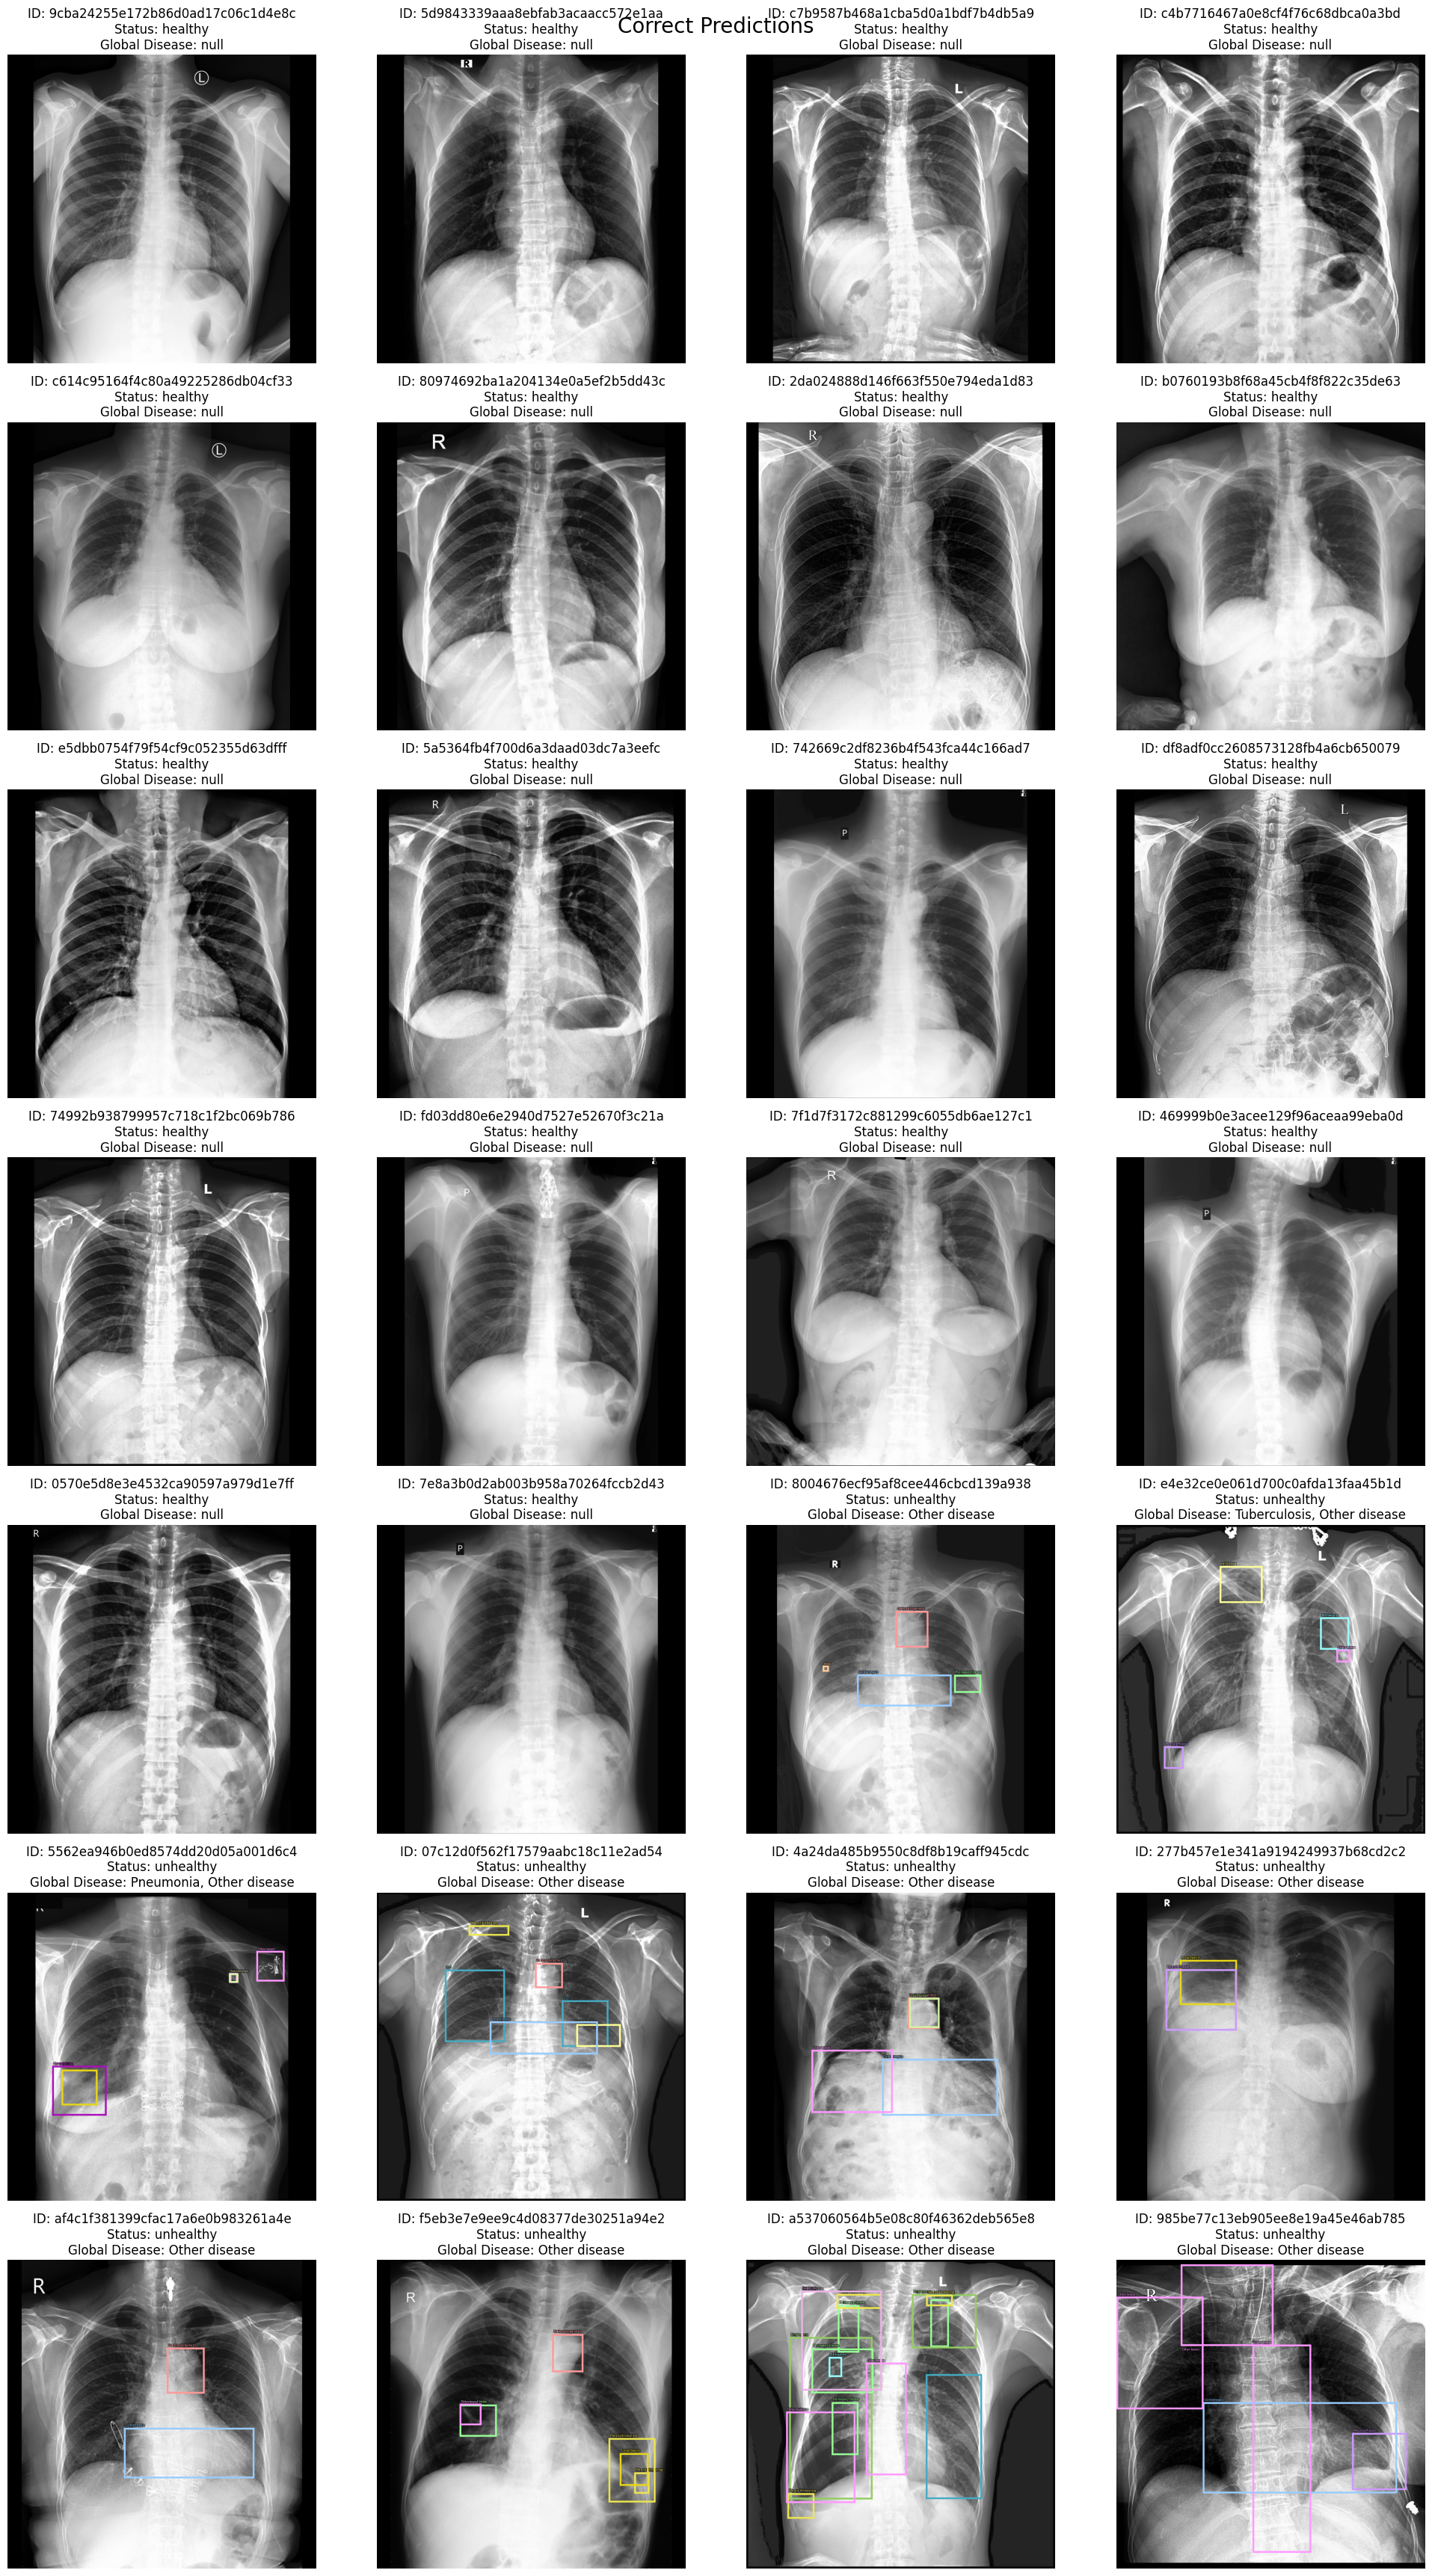

In [48]:
show_images(correct, "Correct Predictions")

### Incorrect Predictions
Show images where the prediction does not match the ground truth.

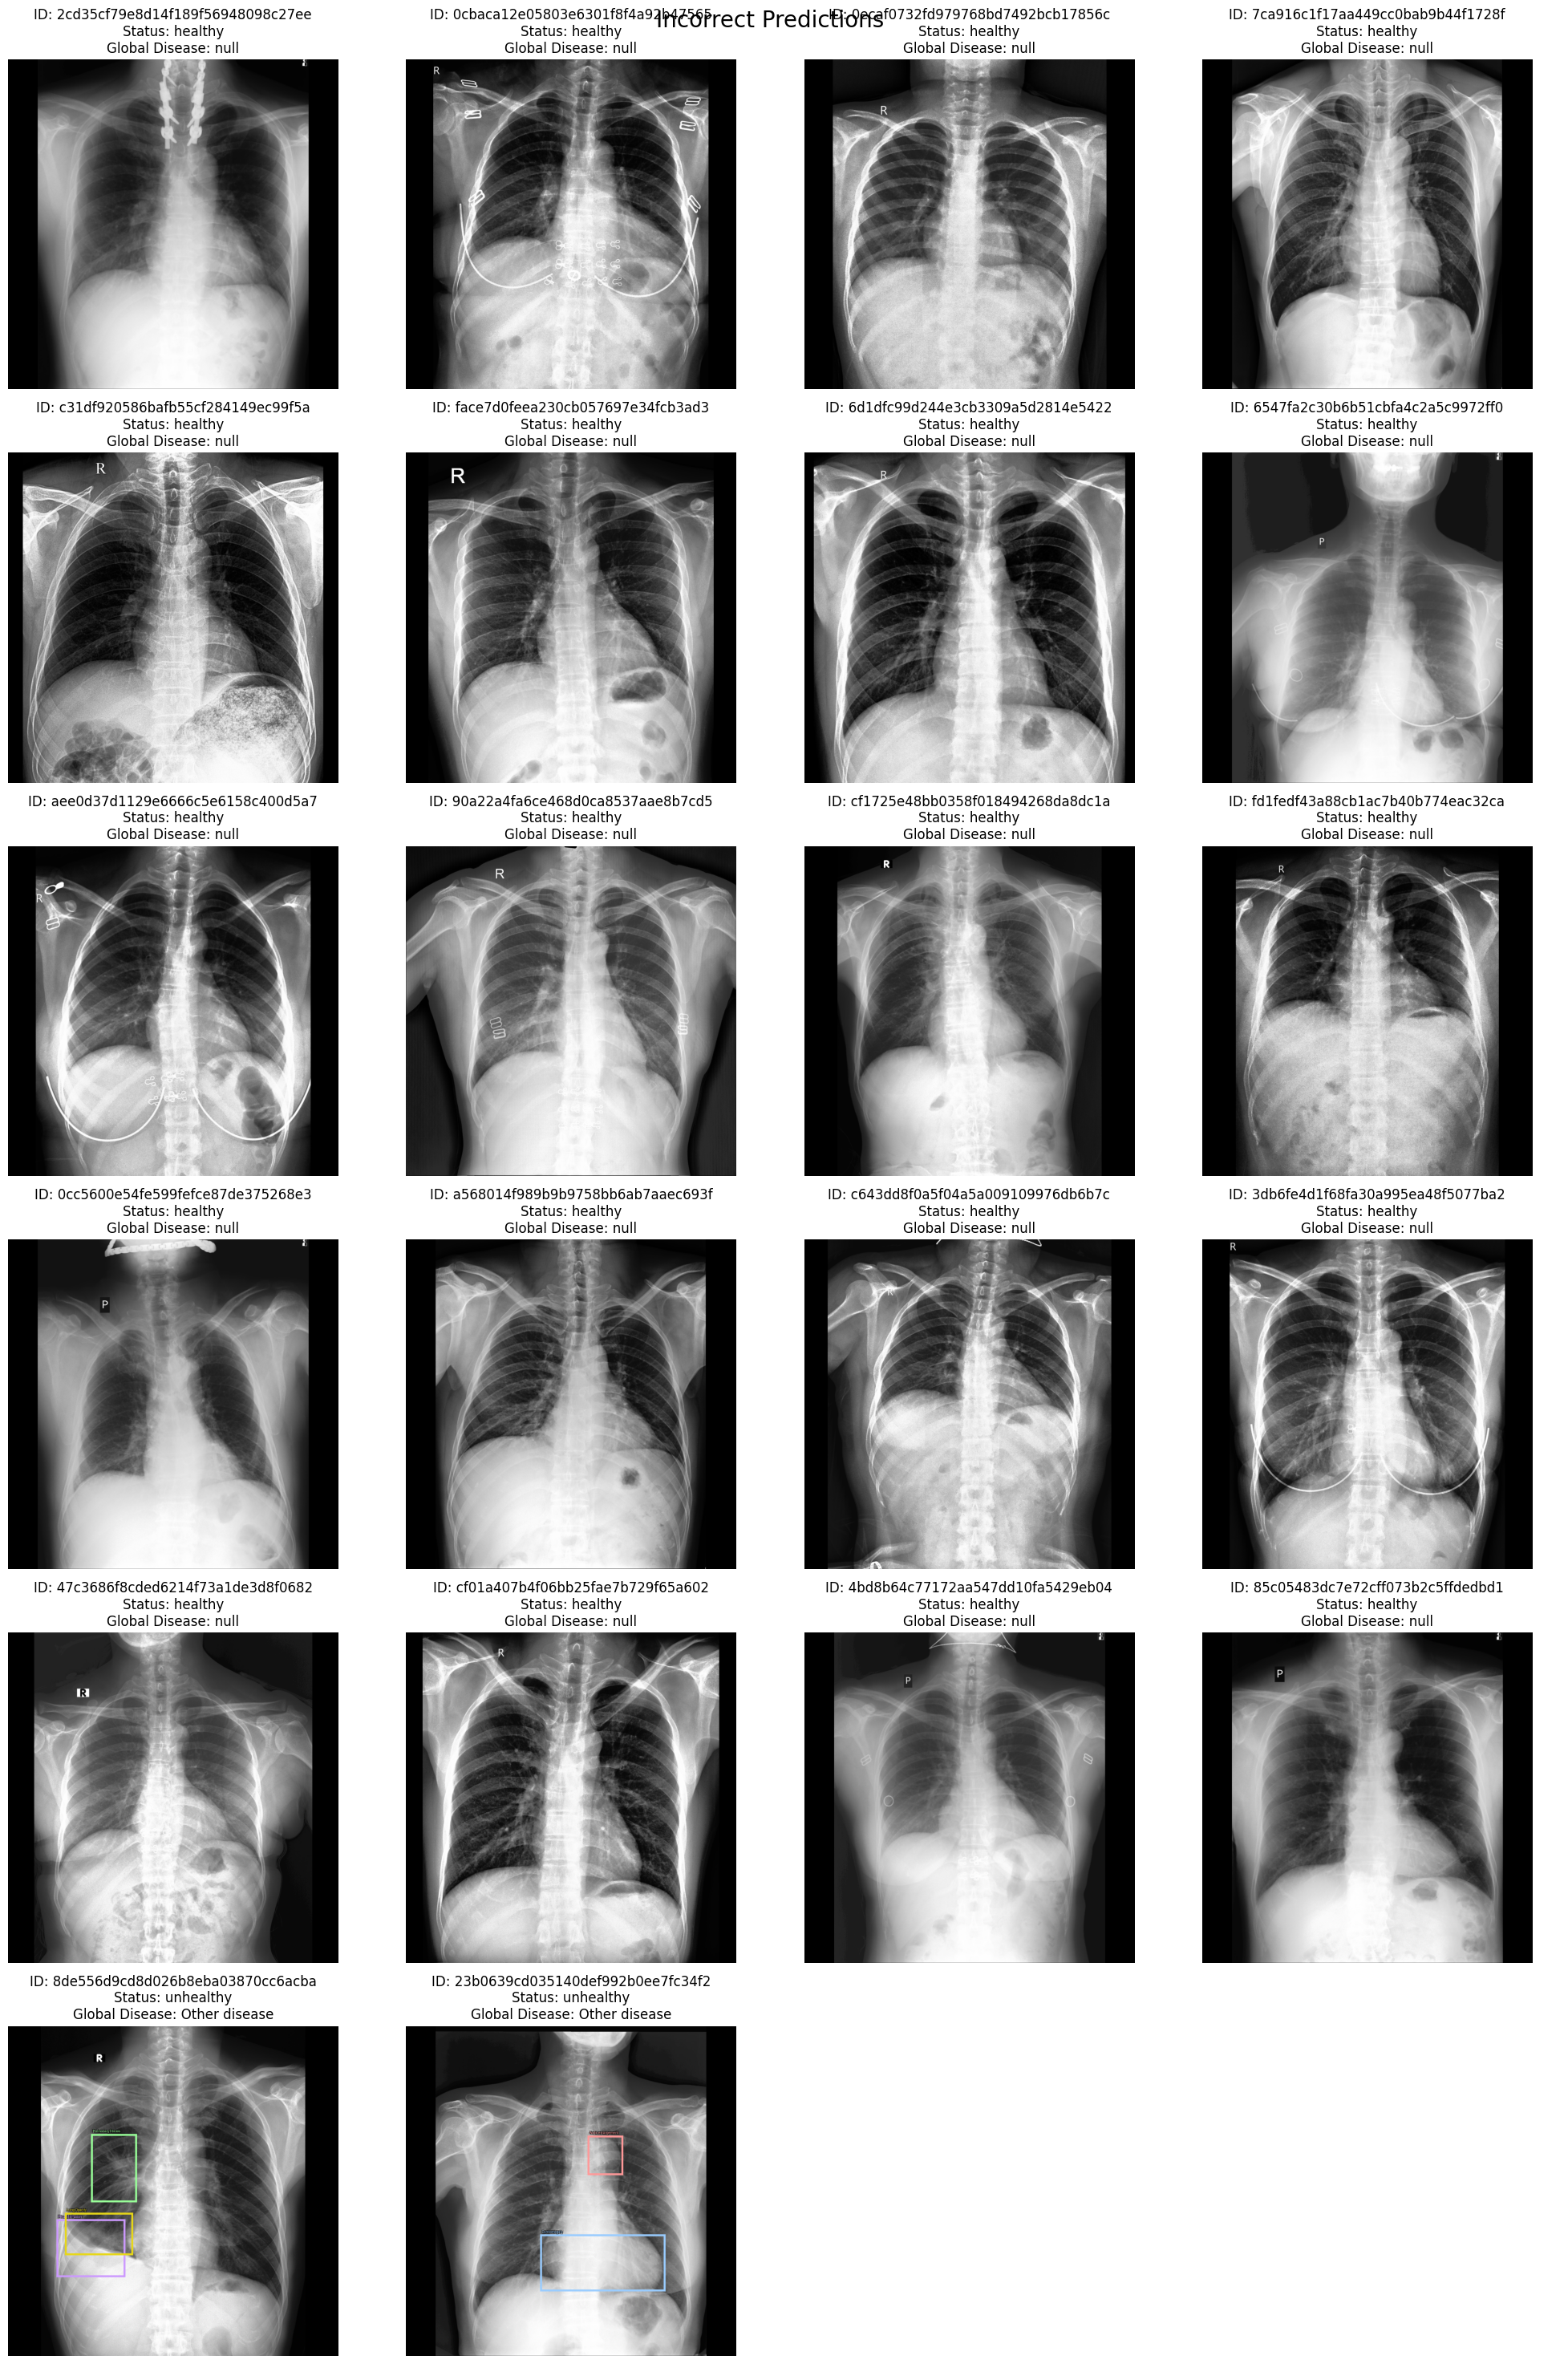

In [49]:
show_images(incorrect, "Incorrect Predictions")